# Travail sur MNIST

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import layers, optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

On se propose d'utiliser le célèbre dataset MNIST, qui renferme une collection d'images de chiffres manuscrits, pour réaliser deux tâches :
* reconnaître les chiffres écrits à l'aide d'un réseau convolutif ;
* ajouter du bruit aux images puis les débruiter en utilisant un réseau autoencodeur.

## Classification d'images avec un réseau convolutif

(60000, 28, 28) (10000, 28, 28)
[5 0 4 ... 5 6 8]


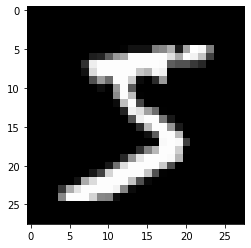

In [15]:
# Importation des données
(train_data, train_lab), (test_data, test_lab) = mnist.load_data()

print(train_data.shape, test_data.shape)
print(train_lab)
plt.imshow(train_data[0], cmap='gray')
plt.show()

On dispose de 60 000 images pour l'ensemble d'apprentissage et 10 000 images pour l'ensemble de test, chacune constituée de 28x28 pixels avec un seul canal de couleur. Chaque image correspond donc à une matrice de 28 lignes et 28 colonnes contenant des valeurs entières allant de 0 à 255. Pour faciliter le fonctionnement de notre réseau, on va normaliser ces valeurs, autrement dit les ramener dans l'intervalle [0,1].

La variable cible - le chiffre auquel correspond chaque image - est donnée sous forme d'entiers allant de 0 à 9. Pour cette tâche de classification multiple, on va recoder cette variable sous forme _one-hot_ : chaque entier est remplacé par un vecteur contenant neuf 0 et un unique 1 à la position correspondante. Par exemple, 3 devient (0 0 0 1 0 0 0 0 0 0).

In [16]:
# Normalisation : on replace les valeurs dans l'intervalle [0, 1]
train_data = train_data.astype("float32") / 255
test_data = test_data.astype("float32") / 255

# Redimensionnement
train_data = train_data.reshape(60000, 28, 28, 1)
test_data = test_data.reshape(10000, 28, 28, 1)

# Recodage "one-hot" des labels
train_lab = to_categorical(train_lab)
test_lab = to_categorical(test_lab)

# Réduction de la taille du dataset
X_train = train_data[:10000] # sélection des 10000 premières observations d'entraînement
y_train = train_lab[:10000]
#selection = np.random.randint(0, 10000, 50)
X_test = test_data[:2000] # sélection aléatoire de 50 observations de test
y_test = test_lab[:2000]


Pour notre réseau convolutif, on utilise des couches `Conv2D` appliquant 32 __filtres de convolution__ de taille 3x3 sur les images d'entrée.

Pour faire simple, chaque filtre de convolution correspond à un motif décrit par une matrice de poids poids. Le filtre est superposé à chaque sous-section de taille 3x3 de l'image d'entrée et fournit pour chacune d'entre elle une valeur (produit scalaire des poids du filtre et des valeurs de la section d'image + biais) indiquant le degré de correspondance au motif.

Chaque filtre permet ainsi de produire une ___feature map___ (ou carte caractéristique) de l'image qu'on résume grâce à la couche `MaxPool2D` qui sélectionne la valeur dominante dans chaque sous-section (sans chevauchement) de taille 2x2 de la _map_. 

__En somme, on dispose pour chaque filtre et pour chaque sous-partie définie de l'image d'une valeur indiquant la présence ou l'absence du motif décrit par le filtre.__ Ces valeurs peuvent ensuite être fournies à un réseau classique à couches denses pour trouver la classe d'appartenance de nos images.

Précisons ici que les motifs décrits par les filtres, soit les poids qu'ils contiennent, sont déterminés par rétro-propagation de l'erreur au cours de l'apprentissage.

In [17]:
# Entrée
entree = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu')(entree)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)

# Sortie
x = layers.Dense(10, activation='softmax')(x)

cnn = Model(entree, x)
cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_3 (Dense)             (None, 32)                147488    
                                                           

In [18]:
cnn.compile(loss = 'categorical_crossentropy',
            optimizer = 'adam',
            metrics = 'accuracy')

cnn.fit(X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=100,
        epochs=10)
        

Epoch 1/10
100/100 [==============================] - 5s 44ms/step - loss: 0.9388 - accuracy: 0.6910 - val_loss: 0.5433 - val_accuracy: 0.8375
Epoch 2/10
100/100 [==============================] - 4s 43ms/step - loss: 0.2887 - accuracy: 0.9191 - val_loss: 0.3673 - val_accuracy: 0.8835
Epoch 3/10
100/100 [==============================] - 4s 42ms/step - loss: 0.1746 - accuracy: 0.9505 - val_loss: 0.1931 - val_accuracy: 0.9450
Epoch 4/10
100/100 [==============================] - 4s 42ms/step - loss: 0.1183 - accuracy: 0.9666 - val_loss: 0.1546 - val_accuracy: 0.9530
Epoch 5/10
100/100 [==============================] - 4s 42ms/step - loss: 0.0811 - accuracy: 0.9762 - val_loss: 0.1386 - val_accuracy: 0.9525
Epoch 6/10
100/100 [==============================] - 4s 42ms/step - loss: 0.0682 - accuracy: 0.9803 - val_loss: 0.1479 - val_accuracy: 0.9590
Epoch 7/10
100/100 [==============================] - 4s 42ms/step - loss: 0.0444 - accuracy: 0.9872 - val_loss: 0.1413 - val_accuracy: 0.9595

On oberve un léger sur-apprentissage, le score d'exactitude obtenu sur l'ensemble d'apprentissage étant sensiblement supérieur à celui obtenu sur l'ensemble de validation. Il est toutefois négligeable dans la mesure où notre réseau parvient à reconnaître correctement le chiffre affiché par près de 96% de nos images de test.

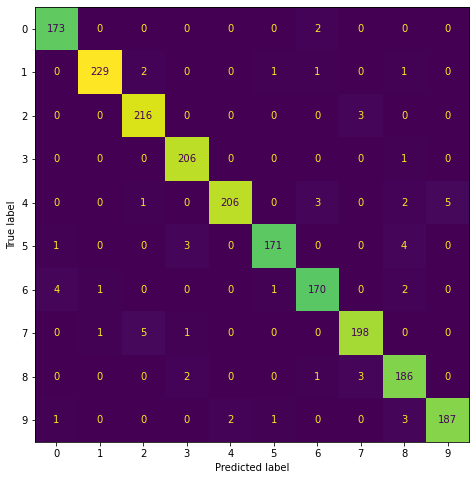

In [19]:
# Matrice de confusion
pred = np.argmax(cnn.predict(X_test, verbose=0), 1)
conf_mat = confusion_matrix(np.argmax(test_lab[:2000], axis=1), pred)
cm = ConfusionMatrixDisplay(conf_mat)
fig, ax = plt.subplots(figsize=(8,8))
cm.plot(ax=ax, colorbar=False)
plt.show()

Pour compléter ces résultats, on valide visuellement notre modèle en mettant en vis-à-vis quelques images tirées de l'ensemble de test et leurs classes prédites.

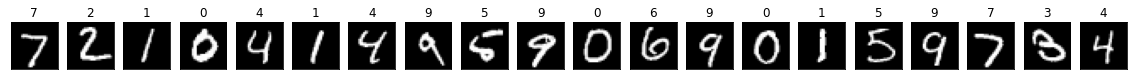

In [20]:
n=20
digits = X_test[:n]
plt.figure(figsize=(20, 5))

for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(digits[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(pred[i])

## Débruitage d'images avec un réseau autoencodeur

Pour cette deuxième partie, on se propose d'ajouter du bruit nos données (réduire leur lisibilité) puis de tenter de les débruiter à l'aide d'un réseau autoencodeur. 

Commençons par créer une fonction de bruitage qu'on va tester sur l'échantillon d'images utilisés ci-dessus.

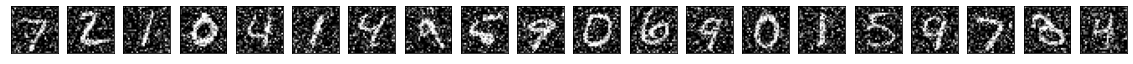

In [8]:
# L'idée est de modifier aléatoirement la valeur de chaque pixel de l'image en prenant soin de la maintenir entre 0 et 1
# On ajoute donc un bruit blanc (variable aléatoire de loi normale centrée) à chaque valeur de pixel
# La fonction np.clip permet ensuite de borner le résultat

bruit = lambda x, strg: np.clip(x + strg * np.random.standard_normal(x.shape), 0, 1)

digits_bruit = bruit(digits, 0.4)

plt.figure(figsize=(20, 5))

for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(digits_bruit[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Le résultat étant concluant, on applique le filtre à l'ensemble de nos données d'apprentissage.

In [9]:
X_bruit = bruit(X_train, 0.4)

Les réseaux autoencodeurs sont des formes d'algorithmes d'apprentissage non-supervisé dans la mesure où la variable cible à partir de laquelle se fait l'ajustement correspond à la variable d'entrée : si on appelle $X$ l'ensemble de données en entrée, le but de l'autoencodeur est généralement de retrouver ces mêmes données $X$ en sortie.

Pour cela, on divise le réseau en deux parties symétriques : une partie __encodeur__ qui condense l'information contenue dans l'entrée en une __représentation latente__ et une partie __décodeur__ chargée de retrouver l'entrée en fonction de cette représentation.

Pour réaliser notre débruitage, on va entraîner un réseau de convolution autoencodeur en utilisant les données bruitées en entrée et les données non-bruitées en cible.

In [10]:
input = layers.Input(shape=(28, 28, 1))

# Encodeur
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
x = layers.MaxPool2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)
x = layers.Dropout(rate=0.2)(x)
# Décodeur 
x = layers.UpSampling2D()(x) # Réciproque de MaxPool
x = layers.Conv2D(1, (3, 3), padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2D(1, (3, 3), padding='same')(x)
x = layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)
# Sigmoid : on compare pixel par pixel avec l'image d'entrée

In [11]:
autoenc = Model(input, x)
autoenc.compile(optimizer='adam', loss='binary_crossentropy')
autoenc.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0   

In [12]:
autoenc.fit(X_bruit, X_train,
            epochs=20,
            batch_size=500,
            shuffle=True)

Epoch 1/20
20/20 [==============================] - 5s 199ms/step - loss: 0.6527
Epoch 2/20
20/20 [==============================] - 4s 192ms/step - loss: 0.4810
Epoch 3/20
20/20 [==============================] - 4s 191ms/step - loss: 0.3572
Epoch 4/20
20/20 [==============================] - 4s 200ms/step - loss: 0.2328
Epoch 5/20
20/20 [==============================] - 4s 192ms/step - loss: 0.1968
Epoch 6/20
20/20 [==============================] - 4s 197ms/step - loss: 0.1795
Epoch 7/20
20/20 [==============================] - 4s 206ms/step - loss: 0.1682
Epoch 8/20
20/20 [==============================] - 4s 210ms/step - loss: 0.1602
Epoch 9/20
20/20 [==============================] - 4s 207ms/step - loss: 0.1540
Epoch 10/20
20/20 [==============================] - 4s 210ms/step - loss: 0.1493
Epoch 11/20
20/20 [==============================] - 4s 217ms/step - loss: 0.1454
Epoch 12/20
20/20 [==============================] - 4s 200ms/step - loss: 0.1420
Epoch 13/20
20/20 [======

On compare de haut en bas les images originales, leur version bruitées et les reconstructions obtenues par notre modèle. Le résultat n'est pas parfait mais on peut voir que notre réseau autoencodeur est parvenu à se débarasser des artefacts créés par notre bruiteur tout en conservant la silhouette des chiffres inscrits.

1/1 [==============================] - 0s 70ms/step


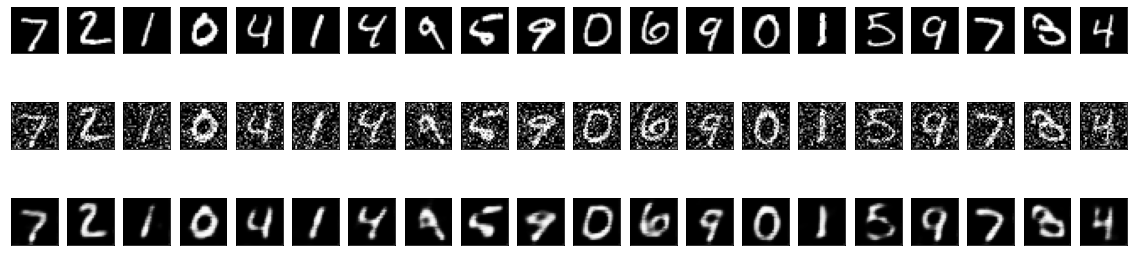

In [13]:
plt.figure(figsize=(20, 5))
digits_debruit = autoenc.predict(digits_bruit)
L_digits = np.concatenate((digits, digits_bruit, digits_debruit))
for i, img in enumerate(L_digits):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()